In [50]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

import hdbscan
import matplotlib.pyplot as plt

import shutil
import os

In [51]:
# Load data
df = pd.read_csv("../data/features.csv")
df2 = pd.read_csv("../data/features_before.csv")

# Separate metadata and features
file_names = df["file_name"]
X = df.drop(columns=["file_name"])
X2 = df2.drop(columns=["file_name"])

In [52]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X2_scaled = scaler.fit_transform(df2.drop(columns=["file_name"]))

# # Optional: remove near-constant features
# X_scaled = VarianceThreshold(threshold=1e-3).fit_transform(X_scaled)

# Fit PCA
pca = PCA(
    n_components=2,
    random_state=42
)

X_pca = pca.fit_transform(X_scaled)
X2_pca = pca.fit_transform(X2_scaled)

# Explained variance (sanity check)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())


Explained variance ratio: [0.29049485 0.21590365]
Total explained variance: 0.5063985026688523


In [53]:
# Fit HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=20,
    min_samples=5,
    metric="euclidean"
)

labels = clusterer.fit_predict(X_pca)
labels2 = clusterer.fit_predict(X2_scaled)

# Attach cluster labels
df["cluster"] = labels
df2["cluster"] = labels2


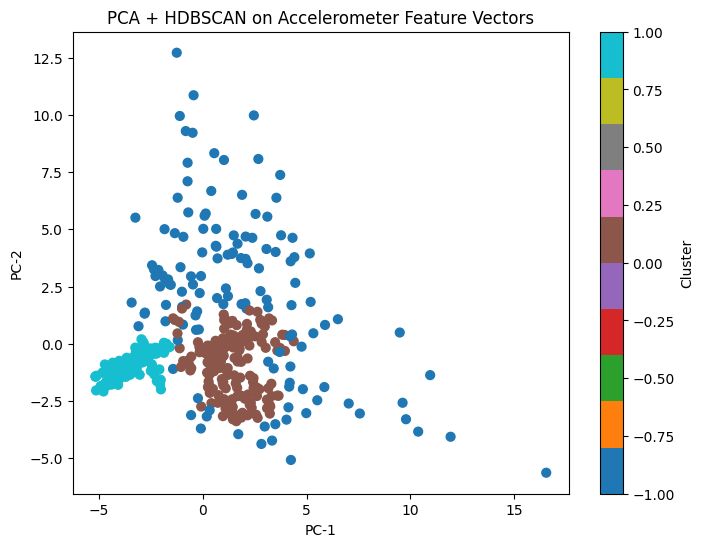

In [54]:
# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=labels,
    cmap="tab10",
    s=40
)
plt.colorbar(label="Cluster", )
plt.title("PCA + HDBSCAN on Accelerometer Feature Vectors")
plt.xlabel("PC-1")
plt.ylabel("PC-2")
plt.show()


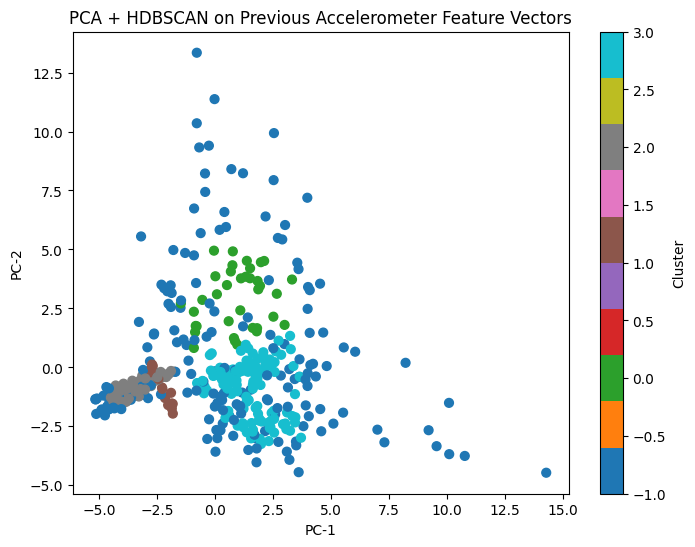

In [55]:
# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(
    X2_pca[:, 0],
    X2_pca[:, 1],
    c=labels2,
    cmap="tab10",
    s=40
)
plt.colorbar(label="Cluster")
plt.title("PCA + HDBSCAN on Previous Accelerometer Feature Vectors")
plt.xlabel("PC-1")
plt.ylabel("PC-2")
plt.show()

In [56]:
# Get unique clusters and get 5 representative samples from each cluster
representative_samples = []
for cluster in np.unique(labels):
    cluster_samples = df[df["cluster"] == cluster]
    representative_samples.append(cluster_samples.sample(n=5, random_state=42))
    print(f"Cluster {cluster}:")
    print(cluster_samples["file_name"].values[:5])  # Print first 5 file names from this cluster
    
    # Get the rep samples from visuals/ boiling_plots and save to new folder visuals/repsamples/PCA-HDBSCAN in subfolders by cluster
    for file in cluster_samples["file_name"].values[:5]:
        # remove.csv and add .png to get the corresponding plot file
        file = file.replace(".csv", ".png")
        src = f"../visuals/boiling_plots/{file}"
        dst = f"../visuals/rep_samples/PCA-HDBSCAN/{cluster}/{file}"
        # Create the destination directory if it doesn't exist
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

Cluster -1:
['Boiling_at_Heater_T85_RefVideo1.csv'
 'Calm_to_Boiling_50V_on_StartT65.csv'
 'MATLAB 1-00 PM Thu, Aug 22, 2024 Run1.csv'
 'MATLAB 1-04 PM Thu, Aug 22, 2024 Run2.csv'
 'MATLAB 1-04 PM Tue, Sep 10, 2024 Run9 .csv']
Cluster 0:
['MATLAB 1-00 PM Fri, Jun 28, 2024 Run8 .csv'
 'MATLAB 1-02 PM Thu, Nov 7, 2024 Run8 .csv'
 'MATLAB 1-05 PM Thu, Aug 22, 2024 Run3 .csv'
 'MATLAB 1-07 PM Fri, Jun 14, 2024 Run1 .csv'
 'MATLAB 1-07 PM Fri, May 31, 2024 Run3 .csv']
Cluster 1:
['Boiling_at_Heater_T93_RefVideo2.csv'
 'Boiling_at_Heater_T98_RefVideo3.csv'
 'Calm_to_Boiling_50V_on_StartT80.csv'
 'MATLAB 1-02 PM Mon, Mar 11, 2024 Run4 .csv'
 'MATLAB 1-05 PM Mon, Mar 11, 2024 Run5 .csv']
